# NAIAD Tutorial

The purpose of this tutorial is to provide a tutorial about the essential functions of NAIAD. We introduce:
1) NAIAD model and workflow for training a model based on genetic perturbation data and predicting new perturbations
2) Active Learning pipeline for iterative selection of "best" perturbations for model improvement (e.g. for lab-in-the-loop experimental designs)
3) Active Learning pipeline with replicates, leveraging ensembling methods to choose the "best" perturbations with higher confidence in iterative data collection and training rounds.

We will use the [Norman2019](https://www.science.org/doi/10.1126/science.aax4438) combinatorial perturbation dataset, which contains cell viability measurements for CRISPRa pairwise genetic perturbations of ~120 genes.

Besides the Norman2019 dataset, you can also try out these models on the [Simpson2023](https://www.biorxiv.org/content/10.1101/2023.08.19.553986v1) and [Horlbeck2018](https://www.cell.com/cell/fulltext/S0092-8674\(18\)30735-9) datasets, present within the `./data` subfolder of this `tutorials` directory.

## Set up notebook

In [1]:
import os
import logging
from datetime import datetime

import pandas as pd
import torch

from naiad import load_naiad_data, NAIAD, ActiveLearner, ActiveLearnerReplicates

In [2]:
# set some configuration settings for the notebook
logging.basicConfig(level=logging.WARN)
pd.set_option("mode.copy_on_write", True)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

## Baseline NAIAD Model

In [3]:
# provide path to relevant data directories
data_file = './data/norman_gamma.csv'
result_dir = './results/naiad'

# parameters for initializing and running model
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
seed = 42

# set up how to split data
n_train = 2000 
n_val = 1000
n_test = 1000
# alternatively, can use fraction of dataset for train / test / val, e.g.
# n_train = 0.5
# n_val = 0.2
# n_test = 0.2
# ...we can even mix absolute counts with fractions, e.g.
# n_train = 0.5
# n_val = 0.1
# n_test = 1000

# how long to run model
n_epoch = 100

In [4]:
# load and split data
naiad_data = load_naiad_data(data_file)
naiad_model = NAIAD(naiad_data, n_train=n_train, n_val=n_val, n_test=n_test)
naiad_model.set_seed(seed=seed)
naiad_model.prepare_data()

# initialize model and prepare trainer
naiad_model.initialize_model(device=device)
naiad_model.setup_trainer(n_epoch=n_epoch)

In [5]:
# run model training
naiad_model.train_model()

In [6]:
# generate predictions
naiad_model.generate_preds(use_best=True) # use_best means using the best model from training based on the validation loss

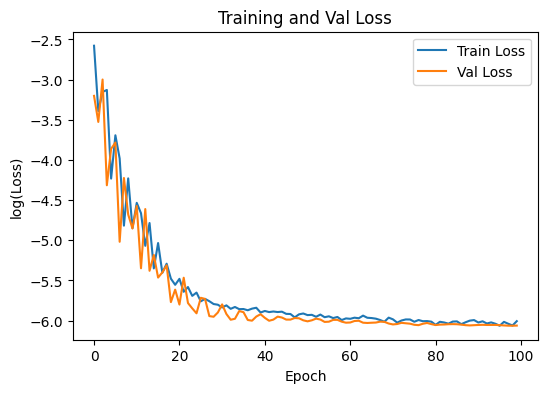

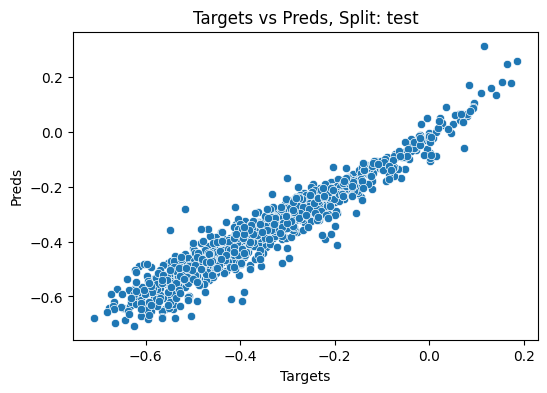

In [7]:
# plot results
fig = naiad_model.plot_loss_curves()
fig = naiad_model.plot_preds('test')

In [8]:
# extract relevant data from object
model = naiad_model.model                 # final model after training
best_model = naiad_model.best_model       # best model after training based on minimum val loss
preds = naiad_model.preds                 # predictions from model on all data splits
losses = naiad_model.training_metrics     # train / val loss during training process

## Active Learning Pipeline

In [9]:
# provide path to relevant data directories
data_file = './data/norman_gamma.csv'
result_dir = './results/active_learning'

# parameters for initializing and running model
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
seed = 42
batch_size = 4096

In [10]:
# active learning pipeline arguments
n_round = 5
n_sample = [100, 200, 300, 400, 500] # number of samples to use in each learning round
test_frac = 0.3

n_rep = 3          # how many replicates to run of active learning pipeline?
n_ensemble = 3     # how many ensembles to use for each round?
n_epoch = 10       # how long to train each instance of the model

method = 'mean'    # active learning method
method_min = True  # method_min checks if we should minimize the value (for 'mean' it is set to True since we are minimizing cell viability)

In [11]:
naiad_data = load_naiad_data(data_file)
active_learner = ActiveLearner(n_round = n_round, 
                               data = naiad_data,
                               n_ensemble = n_ensemble,
                               n_epoch = n_epoch,
                               n_sample = n_sample, 
                               test_frac = test_frac, 
                               early_stop = False,
                               device = device,
                               batch_size = batch_size,
                               method = method, method_min = method_min)

In [12]:
# run active learning pipeline
active_learner.set_seed(seed)
active_learner.shuffle_data()
active_learner.run_active_learning()
active_learner.calculate_aggregate_metrics()

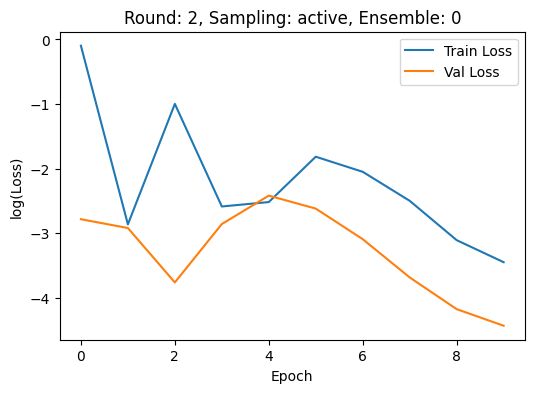

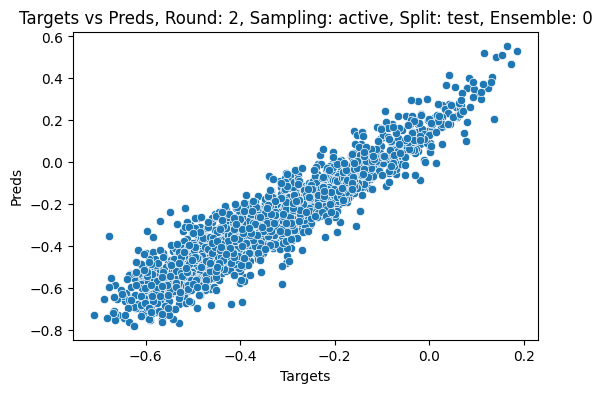

In [13]:
# generate a few plots to confirm that pipeline ran correctly
fig = active_learner.plot_loss_curves(round=2, sampling_type='active', ensemble=0)
fig = active_learner.plot_preds(round=2, sampling_type='active', split='test', ensemble=0)

In [14]:
# extract final predictions from model
preds = active_learner.preds
final_round_preds = preds[n_round-1]['active']['overall']

## Active Learning Pipeline with Replicates

In [15]:
# provide path to relevant data directories
data_source = 'simpson'
data_file = './data/simpson_gamma.csv'

time_label = datetime.now().strftime(r'%Y-%m-%d-%H-%M-%S')
result_dir = os.path.join('./results/active_learning/', f'{data_source}_{time_label}')
os.makedirs(result_dir)

In [16]:
# initialize active learner using same arguments as before
naiad_data = load_naiad_data(data_file)
active_learner = ActiveLearner(n_round = n_round, 
                               data = naiad_data,
                               n_ensemble = n_ensemble,
                               n_epoch = n_epoch,
                               n_sample = n_sample, 
                               test_frac = test_frac, 
                               early_stop = False,
                               device = device,
                               batch_size = batch_size,
                               method = method, method_min = method_min)

active_learner_reps = ActiveLearnerReplicates(n_rep=n_rep, 
                                              overall_seed=seed, 
                                              active_learner=active_learner, 
                                              save_dir=result_dir, save_prefix=data_source)

In [17]:
# run active learning with MPE (maximum predicted effect) selection
active_learner_reps.set_method(method='mean', method_min=True)          # method_min checks if we should minimize the value (for 'mean' it is set to True since we are minimizing cell viability)
results = active_learner_reps.run_replicates(parallel=True)             # parallel distributes the computation for faster processing
aggregated_results = active_learner_reps.aggregate_replicate_metrics(return_value=True)
active_learner_reps.save_aggregated_results(data_source)                # predictions for each round and replicate are stored in result_dir

Now let's generate some plots to visualize the active learning results. Since we selected new points to add to the 
active learning cycle using `method='mean'`, we must specify this same `method` for vusalizing the results.

We will visualize the results for both the MSE loss and the TPR for the mean-selection models and the random-selection models.

The `train` split shows performance on the training data, the `val` split shows performance on the validation data, and the `overall` split shows performance on both the training and actively-selected points.

In order to improve the performance of the active learning workflow, increase `n_epoch` in the ActiveLearner object, and `n_rep` in the ActiveLearnerReplicates object. For processing the Norman dataset in our accompanying publication, we used `n_epoch = 400` with `n_rep = 3`. 

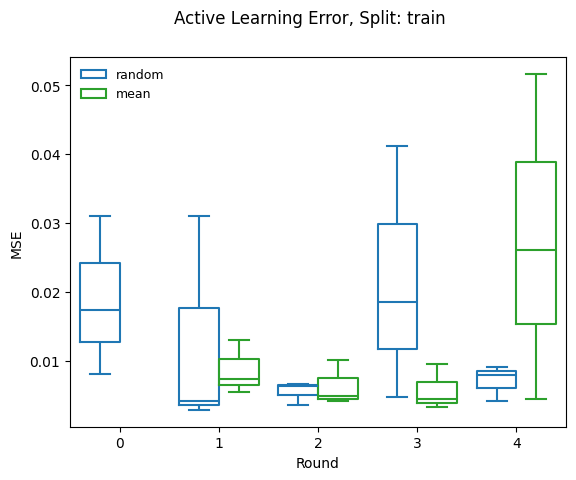

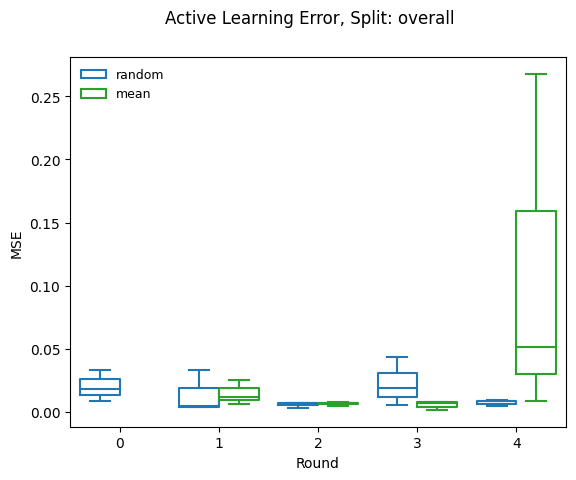

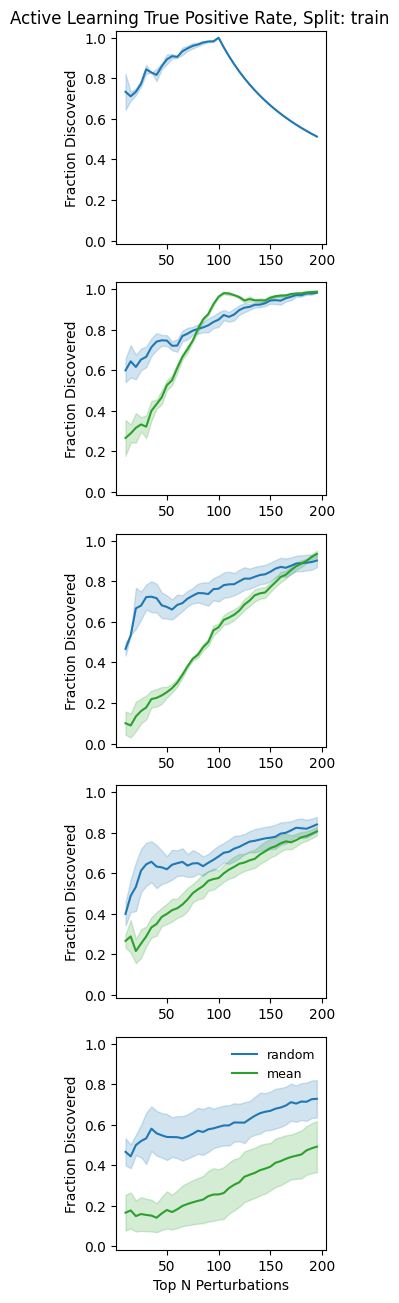

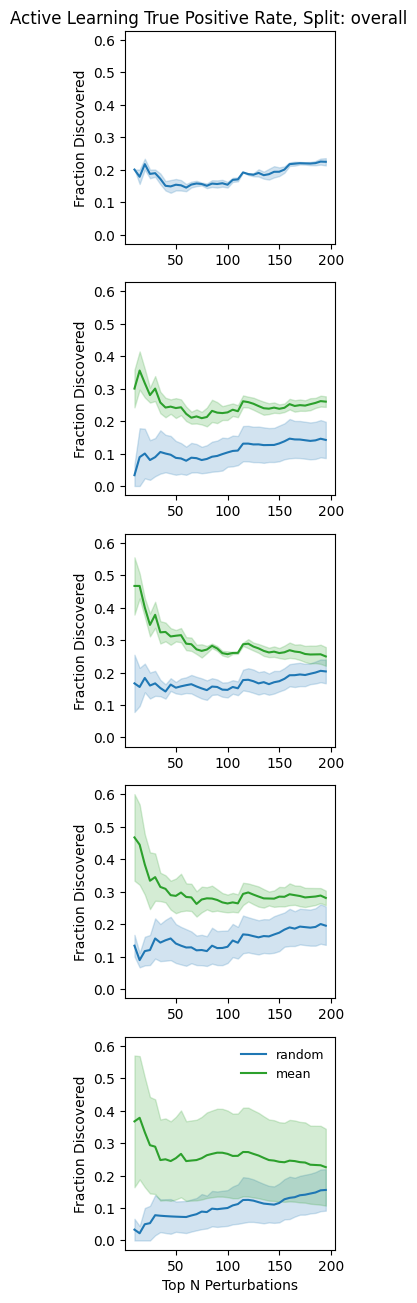

In [18]:
active_learner_reps.plot_aggregated_results(metrics = ['mse', 'tpr'], 
                                            splits = ['train', 'overall'],
                                            methods = 'mean')